# 💪Laboratorio 3: Registro y análisis de señales EMG de superficie usando BITalino
---
## 📖1. Introducción
---
La electromiografía de superficie (sEMG) es una técnica no invasiva que registra la actividad eléctrica del sistema músculo esquelético. Su señal surge de la activación de múltiples unidades motoras (UM), compuestas por una motoneurona y las fibras musculares que inerva. Cuando un potencial de acción alcanza la unión neuromuscular, la liberación de acetilcolina desencadena la despolarización de las fibras, cuyo impulso se propaga bidireccionalmente. Estas contribuciones eléctricas se suman en la superficie cutánea y conforman los potenciales de acción de unidad motora (MUAPs), cuya superposición temporal y espacial origina la señal sEMG, reflejando la organización y el control del sistema neuromuscular [1].

Desde el punto de vista clínico, la sEMG proporciona información esencial sobre el reclutamiento de unidades motoras, la frecuencia de descarga y la coordinación neuromuscular. Esta capacidad la convierte en una herramienta valiosa para estudiar tanto el funcionamiento fisiológico como las alteraciones patológicas del sistema motor.

Recientes investigaciones destacan su utilidad en la rehabilitación neuromuscular, la monitorización de la fatiga y el control de prótesis o interfaces hombre-máquina [2], [3]. Por su carácter no invasivo y su capacidad de ofrecer datos en tiempo real, la sEMG se ha consolidado como una herramienta de evaluación y monitorización ampliamente reconocida en investigación biomédica y en aplicaciones clínicas.

## 🎯2. Objetivos específicos de la práctica de laboratorio
---
- Configurar adecuadamente el sistema BiTalino para la adquisición confiable de señales electromiográficas de superficie.

- Registrar bioseñales musculares mediante sEMG en el bíceps braquial y el músculo flexor radial del carpo, considerando tres condiciones experimentales: reposo, contracción voluntaria lenta y contracción frente a una fuerza aplicada.

- Procesar y analizar las señales electromiográficas adquiridas empleando la plataforma OpenSignals (r)evolution en conjunto con herramientas de programación en Python.

- Interpretar los patrones de activación muscular obtenidos, estableciendo su relación con los fundamentos fisiológicos de los músculos estudiados.

## 🧰3. Materiales y Recursos Utilizados
---
| Modelo / Equipo                       | Descripción                                                                                      | Cantidad |
|--------------------------------------|--------------------------------------------------------------------------------------------------|----------|
| BITalino (r)evolution (Bluetooth)    | Kit de adquisición de bioseñales, incluye módulo de EMG, cable de tres conductores y batería LiPo de 3.7 V – 500 mA. | 1        |
| Electrodos adhesivos de superficie    | Sensores desechables para la captación de la actividad eléctrica muscular.                       | 3        |
| Laptop / PC                           | Computador portátil empleado para la configuración, registro de señales con OpenSignals (r)evolution y análisis posterior en Python. | 1        |


| <img src="images/bitalino_kit.jpeg" width="200px"> | <img src="images/electrodos_superficie.jpeg" width="200px"> | <img src="images/laptop_open_signals.jpeg" width="200px"> |
|:--------------------------------------------------:|:------------------------------------------------------------:|:----------------------------------------------------------:|
| **(a)** BITalino (r)evolution                     | **(b)** Electrodos adhesivos de superficie                  | **(c)** Laptop / PC                                        |

**Figura 1.** Equipos y materiales empleados en la práctica de adquisición de señales EMG. (a) Kit BITalino, (b) electrodos adhesivos para la captación de la actividad muscular, (c) computadora utilizada para adquisición y análisis de datos.

## 🧪4. Procedimiento
---
Calint
## 📊5. Resultados
---
## 📝6. Conclusiones
---
## 📚7. Referencias
---
[1] https://www.mdpi.com/1424-8220/22/11/4150
[2] https://www.mdpi.com/2079-9292/12/7/1520
[3] https://pmc.ncbi.nlm.nih.gov/articles/PMC10382439/ 
## 📂8. Anexos
---

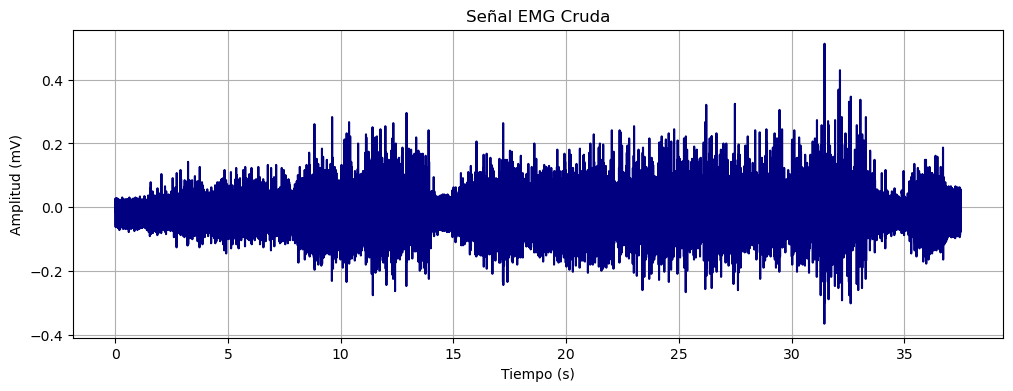

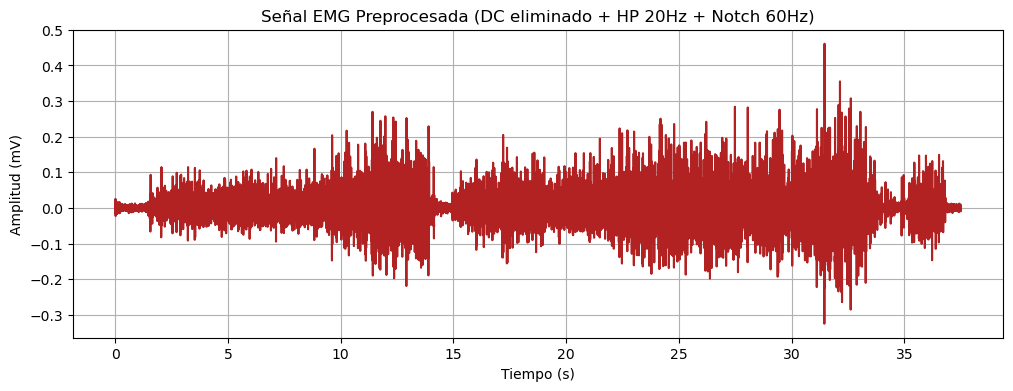

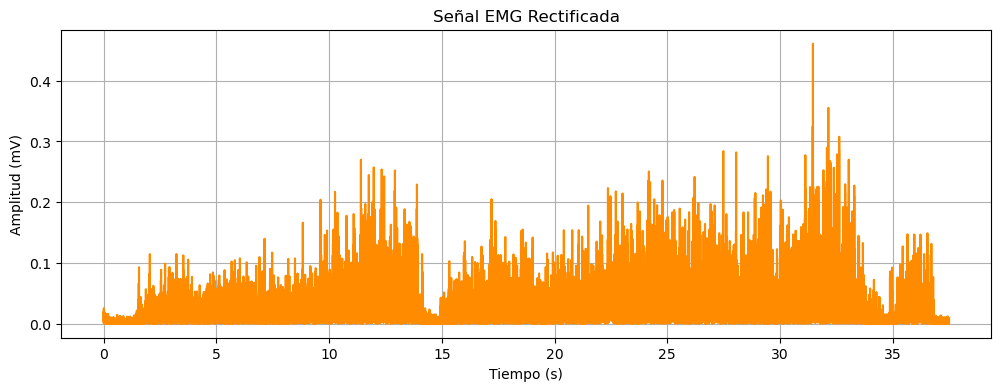

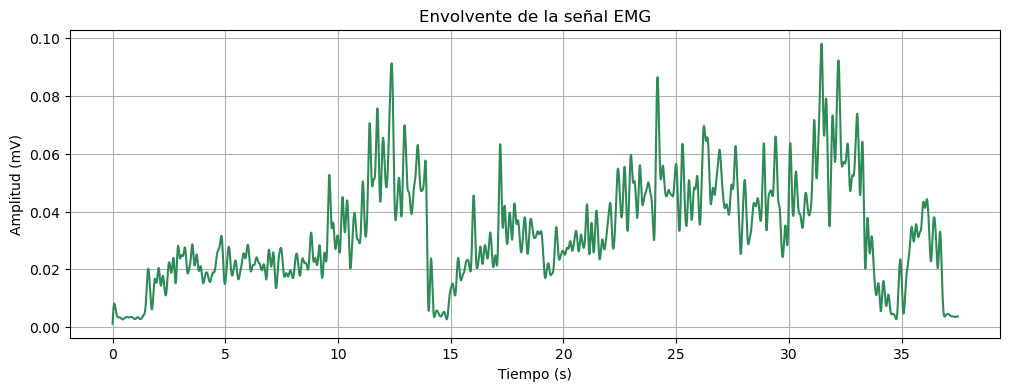

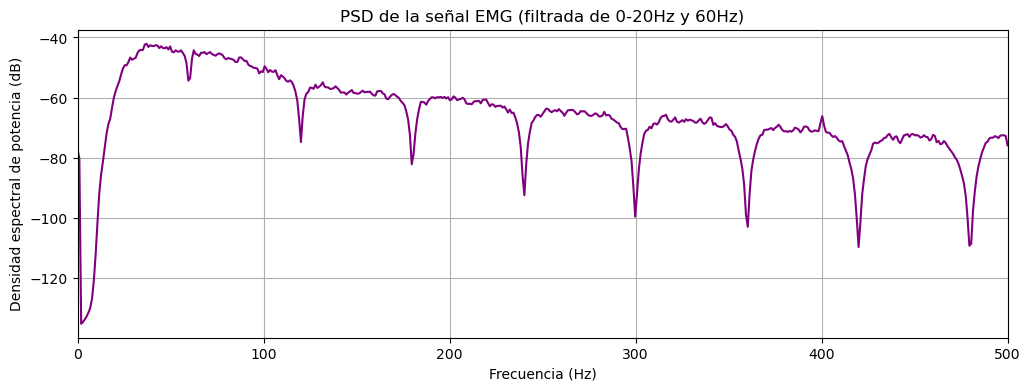

Frecuencias de picos detectados (Hz): [ 25.390625   28.3203125  37.109375   39.0625     41.9921875  44.921875
  47.8515625  49.8046875  52.734375   55.6640625  62.5        66.40625
  68.359375   71.2890625  76.171875   81.0546875  87.890625   90.8203125
  95.703125   98.6328125 100.5859375 103.515625  106.4453125 109.375
 114.2578125 125.        127.9296875 131.8359375 138.671875  142.578125
 147.4609375 153.3203125 155.2734375 157.2265625 163.0859375 169.921875
 190.4296875 193.359375  195.3125    197.265625  199.21875   202.1484375
 207.03125  ]


In [125]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.signal import welch, find_peaks

# === 1. Leer archivo de EMG ===
ruta = r"C:\SeñalesLab3\Lento1Biceps.txt"
df = pd.read_csv(ruta, sep="\t", comment="#",
                 names=["nSeq", "I1", "I2", "O1", "O2", "A1"])

# === 2. Extraer canal O2 ===
ADC = df["O2"].values  # Canal de interés

# === 3. Parámetros del sensor ===
VCC = 3.3
Gain = 1009
ADCres = 1023
fs = 1000  # Frecuencia de muestreo en Hz

# === 4. Conversión ADC → mV ===
EMG_V = ((ADC / ADCres) - 0.5) * VCC / Gain  # Señal en volts
EMG_mV = EMG_V * 1000  # Convertir a mV

# === 5. Quitar componente DC ===
EMG_noDC = EMG_mV - EMG_mV.mean()  # Centrar la señal alrededor de 0

# === 6. Filtro pasa-altas 20 Hz ===
fc = 20  # Frecuencia de corte en Hz
b, a = signal.butter(4, fc/(fs/2), btype='high')  # Butterworth 4º orden
EMG_filtered = signal.filtfilt(b, a, EMG_noDC)  # Filtrado sin desfase

# === 6b. Filtro notch 60 Hz y armónicos hasta 480 Hz ===
EMG_clean = EMG_filtered.copy()
Q = 30  # Factor de calidad para notch (estrecho)
for f_h in np.arange(60, 481, 60):  # 60, 120, 180, ..., 480 Hz
    b_notch, a_notch = signal.iirnotch(f_h, Q, fs)
    EMG_clean = signal.filtfilt(b_notch, a_notch, EMG_clean)  # Aplicar notch

# === 7. Vector de tiempo ===
t = np.arange(len(EMG_clean)) / fs  # Tiempo en segundos

# === 8. Graficar señal cruda ===
plt.figure(figsize=(12,4))
plt.plot(t, EMG_mV, color='navy')
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud (mV)")
plt.title("Señal EMG Cruda")
plt.grid(True)
plt.show()

# === Graficar señal preprocesada (DC eliminado + HP + Notch) ===
plt.figure(figsize=(12,4))
plt.plot(t, EMG_clean, color='firebrick')
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud (mV)")
plt.title("Señal EMG Preprocesada (DC eliminado + HP 20Hz + Notch 60Hz)")
plt.grid(True)
plt.show()

# === 9. Rectificación de la señal ===
EMG_rect = np.abs(EMG_clean)  # Valor absoluto para eliminar negativas
plt.figure(figsize=(12,4))
plt.plot(t, EMG_rect, color='darkorange')
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud (mV)")
plt.title("Señal EMG Rectificada")
plt.grid(True)
plt.show()

# === 10. Calcular envolvente con filtro pasa-bajo 5 Hz ===
fc_env = 5  # Frecuencia de corte para suavizar la señal
b_env, a_env = signal.butter(4, fc_env/(fs/2), btype='low')
EMG_envelope = signal.filtfilt(b_env, a_env, EMG_rect)
plt.figure(figsize=(12,4))
plt.plot(t, EMG_envelope, color='seagreen')
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud (mV)")
plt.title("Envolvente de la señal EMG")
plt.grid(True)
plt.show()

# === 11. PSD (densidad espectral de potencia) en dB usando Welch ===
f_psd, Pxx = welch(EMG_clean, fs=fs, nperseg=1024)  # PSD de la señal filtrada
Pxx_dB = 10 * np.log10(Pxx)  # Convertir a dB

# === Detectar picos en la PSD (opcional) ===
peaks, _ = find_peaks(Pxx_dB, height=np.mean(Pxx_dB)+6)

# === Graficar PSD en dB ===
plt.figure(figsize=(12,4))
plt.plot(f_psd, Pxx_dB, color='purple')  # Solo línea de PSD
plt.xlabel("Frecuencia (Hz)")
plt.ylabel("Densidad espectral de potencia (dB)")
plt.title("PSD de la señal EMG (filtrada de 0-20Hz y 60Hz)")
plt.xlim(0, 500)
plt.grid(True)
plt.show()

# === Mostrar frecuencias de picos detectados ===
print("Frecuencias de picos detectados (Hz):", f_psd[peaks])
